# BERT

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# === Set random seed ===
np.random.seed(691)
torch.manual_seed(691)

In [4]:
# === Load data ===
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

target_col = 'label_id'
num_classes = train_df[target_col].nunique()

In [5]:
# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# === Dataset ===
class LIARBertDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['statement'].astype(str).tolist()
        self.labels = df[target_col].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)

        return item

In [7]:
# === Datasets ===
train_ds = LIARBertDataset(train_df, tokenizer)
val_ds = LIARBertDataset(val_df, tokenizer)
test_ds = LIARBertDataset(test_df, tokenizer)

In [8]:
# === Data collator ===
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
# === Model ===
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# === Patch model forward to optionally use class weights ===
from transformers.modeling_outputs import SequenceClassifierOutput

original_forward = model.forward

def custom_forward(input_ids=None, attention_mask=None, labels=None, **kwargs):
    # Only pass supported args to original_forward
    outputs = original_forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    loss = None
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, num_classes), labels.view(-1))

    return SequenceClassifierOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions
    )


model.forward = custom_forward

In [11]:
# === Compute metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
# === TrainingArguments ===
training_args = TrainingArguments(
    output_dir="./bert_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_first_step=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none",
    save_total_limit=1
)

In [13]:
# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [14]:
# === Train ===
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.736500,1.726487,0.250000,0.191246,0.209793,0.250000
2,1.648300,1.727612,0.245327,0.227154,0.244496,0.245327
3,1.451600,1.800569,0.242212,0.233792,0.244301,0.242212
4,1.203400,2.005136,0.260903,0.252986,0.260403,0.260903
5,0.938300,2.257040,0.253115,0.252030,0.265179,0.253115
6,0.724800,2.517475,0.254673,0.254704,0.260634,0.254673
7,0.553800,2.849725,0.247664,0.246807,0.270691,0.247664
8,0.424100,3.073491,0.260903,0.261144,0.272147,0.260903
9,0.333300,3.239074,0.253115,0.253279,0.263517,0.253115
10,0.271800,3.319640,0.250779,0.251360,0.267404,0.250779


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=6400, training_loss=0.9286116676218807, metrics={'train_runtime': 2481.7479, 'train_samples_per_second': 41.261, 'train_steps_per_second': 2.579, 'total_flos': 6735884923699200.0, 'train_loss': 0.9286116676218807, 'epoch': 10.0})

In [15]:
# === Evaluate on Validation set ===
print("\nValidation Set Evaluation:")
outputs_val = trainer.predict(val_ds)
trainer.evaluate(eval_dataset=val_ds)


Validation Set Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.726487159729004,
 'eval_accuracy': 0.25,
 'eval_f1': 0.19124624948707383,
 'eval_precision': 0.20979332439170426,
 'eval_recall': 0.25,
 'eval_runtime': 8.5964,
 'eval_samples_per_second': 149.365,
 'eval_steps_per_second': 4.769,
 'epoch': 10.0}

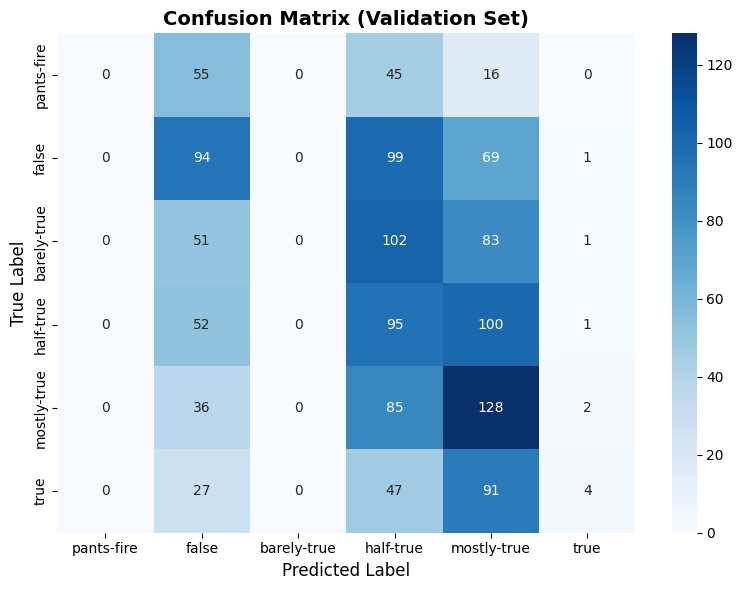

In [16]:
# Plot CM for Validation set
val_logits = outputs_val.predictions
val_labels = outputs_val.label_ids
val_preds = np.argmax(val_logits, axis=1)

cm_val = confusion_matrix(val_labels, val_preds)
label_names = train_df[['label_id', 'label']].drop_duplicates().sort_values('label_id')['label'].tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Validation Set)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# === Evaluate on Test set ===
print("\nTest Set Evaluation:")
outputs_test = trainer.predict(test_ds)
trainer.evaluate(eval_dataset=test_ds)


Test Set Evaluation:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.711954951286316,
 'eval_accuracy': 0.244672454617206,
 'eval_f1': 0.18315214643472918,
 'eval_precision': 0.17912704461821952,
 'eval_recall': 0.244672454617206,
 'eval_runtime': 8.665,
 'eval_samples_per_second': 146.22,
 'eval_steps_per_second': 4.616,
 'epoch': 10.0}

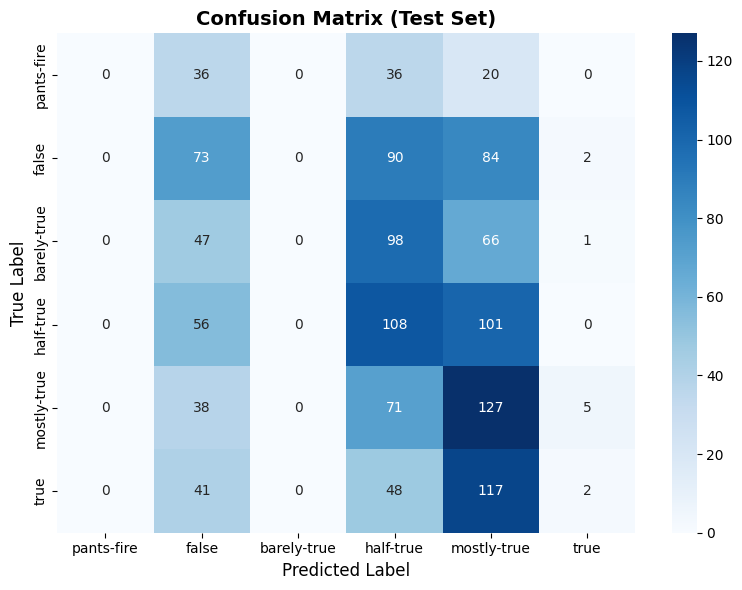

In [18]:
# Plot CM for Test set
test_logits = outputs_test.predictions
test_labels = outputs_test.label_ids
test_preds = np.argmax(test_logits, axis=1)

cm_test = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()